In [60]:
import torch
import pandas as pd
import numpy as np
from torch.utils.data import Dataset, TensorDataset, DataLoader, WeightedRandomSampler
from torch import nn
import torchvision.transforms as T
from collections import defaultdict
import matplotlib.pyplot as plt

In [73]:
df = pd.read_csv('Saved Data/Groups/training_groups.csv')

In [74]:
print(max(df['Labels']))

99.0


In [84]:
train_images = torch.load('Saved Data/Data/train_images.pt')
train_labels = torch.load('Saved Data/Data/train_labels.pt')
test_images = torch.load('Saved Data/Data/test_images.pt')
test_labels = torch.load('Saved Data/Data/test_labels.pt')
val_images = torch.load('Saved Data/Data/val_images.pt')
val_labels = torch.load("Saved Data/Data/val_labels.pt")

/var/folders/bn/hglmht2s7y19n14x7s3vfm2m0000gn/T/ipykernel_59703/202199018.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  train_images = torch.load('Saved Data/Data/tra

Define a Dataset class that take in the image, the label, and what subcluster group it belongs to

In [64]:
class GroupData(Dataset):
    def __init__(self,images, labels, groups):
        self.image = images
        self.label = labels
        self.group = groups

    def __len__(self):
        return len(self.image)
    
    def __getitem__(self, index):
        return self.image[index], self.label[index], self.group[index]

Create a weighted random sampler to ensure that all groups are equally included in a batch

In [76]:
class_counts = df.value_counts()
sample_weights = [1/class_counts[i] for i in df['Labels']]
sampler = WeightedRandomSampler(weights=sample_weights, num_samples=len(sample_weights))

Create the dataloaders. The batch size is 500

In [85]:
train_data = GroupData(train_images, train_labels, df['Labels'])
train_dataloader = DataLoader(train_data,sampler = sampler, batch_size=500)
test_data = TensorDataset(test_images, test_labels)
test_dataloader = DataLoader(test_data, 5)
val_data = TensorDataset(val_images, val_labels)
val_dataloader = DataLoader(val_data, 5)

Redefine the model architecture

In [67]:
class LeNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = torch.nn.Sequential(
            nn.Conv2d(3,9,(5,5)),
            nn.ReLU(),
            nn.MaxPool2d((2,2)),
            nn.Conv2d(9,18,(5,5)),
            nn.ReLU(),
            nn.MaxPool2d((2,2)),
            nn.Flatten(1,-1),
            nn.Linear(288,64)
            )
        self.relu = nn.ReLU()
        self.l = nn.Linear(64,5)

    def forward(self, x):
        x = self.net(x)
        x = self.relu(x)
        return self.l(x)

Train the model. We use a learning rate of 0.00005, and train for 150 epochs. We have 2 loss functions because one is used for training and the other is used for testing. We don't reduce the values from the loss function because we want to know the loss of each individual value so we can record it and find the worst group. We don't use a learning rate reducer due to the volatility of the testing loss(visualized below)

In [69]:
model = LeNet()
optimizer = torch.optim.AdamW(model.parameters(), lr = 0.0005)
loss_fn = nn.CrossEntropyLoss(reduction='none')
loss_fn2 = nn.CrossEntropyLoss()
transform = T.Compose([
    T.Normalize(mean=(0.5,0.5,0.5), std=(0.5,0.5,0.5))
])
test_loss = []
train_loss = []

epochs = 300
best_loss = 100
for epoch in range(epochs):
    group_losses = defaultdict(float)
    group_num = defaultdict(int)
    model.train()
    worst_loss = 0
    for x,y,groups in train_dataloader:
        x = transform(x)
        y_pred = model(x)
        loss = loss_fn(y_pred,y)
        optimizer.zero_grad()
        for group in groups.unique():
            group_mask = (groups == group)
            group_losses[group.item()] += loss[group_mask.squeeze()].mean().item()
            group_num[group.item()] += len(loss[group_mask.squeeze()])
        
        worst_group = max(group_losses, key = lambda g: group_losses[g] / group_num[g])
        loss[groups == worst_group].mean().backward()
        current_worst_loss = loss[groups == worst_group].mean().item()

        if current_worst_loss > worst_loss:
            worst_loss = current_worst_loss

        optimizer.step()
    train_loss.append(worst_loss)
    model.eval()
    with torch.no_grad():
        tot_loss = 0
        for x,y in val_dataloader:
            x = transform(x)
            y_pred = model(x)
            loss = loss_fn2(y_pred, y)
            tot_loss += loss.item()
        tot_loss /= len(val_dataloader)
        test_loss.append(tot_loss)
    
    if(tot_loss <= best_loss):
        torch.save(model.state_dict(),'Saved Data/models/model2.pt')
        best_loss = tot_loss

    print(f"Epoch {epoch+1}: Worst Group Loss = {train_loss[-1]:.4f}, Average Group Loss = {np.mean(train_loss[max(0,len(train_loss)-20):]):.4f}, Validation Loss = {test_loss[-1]:.4f}, Average Validation Loss = {np.mean(test_loss[max(0,len(test_loss)-20):]):.4f}")

Epoch 1: Worst Group Loss = 2.7283, Average Group Loss = 2.7283, Validation Loss = 1.4385, Average Validation Loss = 1.4385
Epoch 2: Worst Group Loss = 3.4663, Average Group Loss = 3.0973, Validation Loss = 1.7018, Average Validation Loss = 1.5701
Epoch 3: Worst Group Loss = 2.6663, Average Group Loss = 2.9536, Validation Loss = 1.5743, Average Validation Loss = 1.5715
Epoch 4: Worst Group Loss = 4.2744, Average Group Loss = 3.2838, Validation Loss = 1.3778, Average Validation Loss = 1.5231
Epoch 5: Worst Group Loss = 3.0020, Average Group Loss = 3.2274, Validation Loss = 1.6291, Average Validation Loss = 1.5443
Epoch 6: Worst Group Loss = 2.1926, Average Group Loss = 3.0550, Validation Loss = 1.5205, Average Validation Loss = 1.5403
Epoch 7: Worst Group Loss = 2.1587, Average Group Loss = 2.9269, Validation Loss = 1.5987, Average Validation Loss = 1.5487
Epoch 8: Worst Group Loss = 1.7878, Average Group Loss = 2.7845, Validation Loss = 1.4801, Average Validation Loss = 1.5401
Epoch 9:

Visualize the loss over each epoch

/opt/anaconda3/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


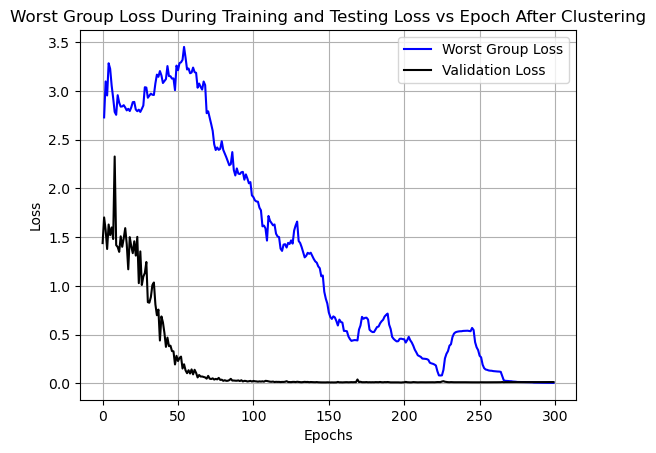

In [70]:
#rolling windown of size 20 to reduce the variance of the worst group loss, so that we can see the underlying improvements and not the individual variations
plt.plot([np.mean(train_loss[max(0, i-20):i]) for i in range(len(train_loss))], label = "Worst Group Loss", color = "blue")
plt.plot(test_loss, label = "Validation Loss", color = 'black')
plt.grid(True)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Worst Group Loss During Training and Testing Loss vs Epoch After Clustering")
plt.legend()

In [88]:
num_correct = 0
model.eval()
model.load_state_dict(torch.load("Saved Data/models/model2.pt", weights_only=True))
with torch.no_grad():
    for x,y in test_dataloader:
        y_pred = model(transform(x))
        num_correct += (torch.argmax(y_pred, dim=1) == y).sum().item()
print(f"Accuracy: {100 * num_correct/(len(test_dataloader) * 5):.2f}%")

Accuracy: 70.46%


Robust Accuracy: 16.28% over 86 occurances for group 56.0


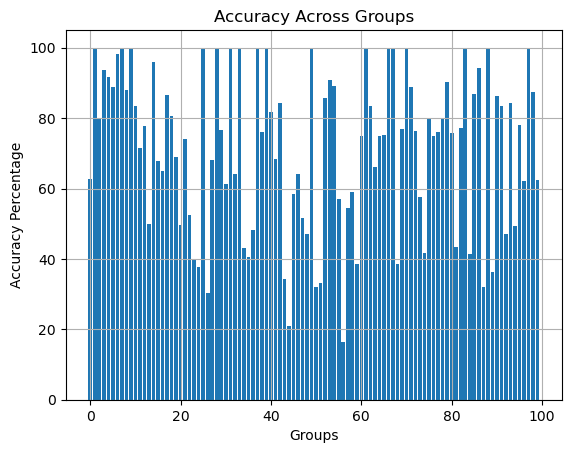

In [ ]:
df_train = pd.read_csv('Saved Data/Groups/testing_groups.csv')

class GroupData(Dataset):
    def __init__(self,images, labels, groups):
        self.image = images
        self.label = labels
        self.group = groups

    def __len__(self):
        return len(self.image)
        
    def __getitem__(self, index):
        return self.image[index], self.label[index], self.group[index]
        
test_data = GroupData(test_images, test_labels, df['Labels'])
test_dataloader = DataLoader(test_data, 100)

group_acc = defaultdict(float)
group_num = defaultdict(int)
model.eval()
for x,y,groups in test_dataloader:
    y_pred = model(transform(x))
    num_correct = (torch.argmax(y_pred, dim=1) == y)
        
    for group in groups.unique():
        group_mask = (groups == group)
        group_acc[group.item()] += torch.sum(num_correct[group_mask])
        group_num[group.item()] += len(num_correct[group_mask])

plt.bar(df['Labels'].unique(),[100 * group_acc[g] / group_num[g] for g in df['Labels'].unique()])
plt.xlabel("Groups")
plt.ylabel("Accuracy Percentage")
plt.title("Accuracy Across Groups")
plt.grid()
plt.plot()

worst_group = min(df['Labels'].unique(), key = lambda g: group_acc[g] / group_num[g])
print(f"Robust Accuracy: {100 * group_acc[worst_group] / group_num[worst_group]:.2f}% over {group_num[worst_group]} occurances for group {worst_group}")